In [1]:
# Importar bibliotecas

# from rasterstats import zonal_stats
import rasterio
from rasterio import plot
from rasterio.plot import show
import os
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import numpy.ma as ma
from osgeo import gdal
import gdal
# from gdalconst import *
import glob
import re
import geopandas as gpd
from rasterio.mask import mask
import fiona
from rasterio.features import sieve

In [2]:
def read_file(file):
    with rasterio.open(file) as src:
        return (src.read(1))

In [3]:
def read_file_target(raster, shape):
    with rasterio.open(raster) as src:
        out_image, out_transform = mask(src, shape, crop=True, invert=False, all_touched=False)
        profile = src.profile
        out_meta = src.meta
        return out_image, out_transform, out_meta, profile

In [13]:
def read_file_lc(raster, shape):
    with rasterio.open(raster) as src:
        out_image, out_transform = mask(src, shape, crop=True, invert=False, all_touched=False)
#         out_image[out_image==0] = np.nan
        return out_image

In [22]:
def read_file_lc(raster, shape):
    with rasterio.open(raster) as dataset, fiona.open(shape, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
        masked_data = rasterio.mask.mask(dataset, shapes, invert=True)

In [4]:
lcdir = r'E:\acocac\research\AMZ\eval\pred\4_local\ep15\convgru\convgru128_010203_adam_fold0_MCD12Q1v6stable01to15_LCProp2_major_84993\2005'
lc_list = glob.glob(os.path.join(lcdir, '*.vrt'))
lc_list.sort(key=lambda f: int(re.sub('\D', '', f)))

In [6]:
aoi_file = r'F:\acoca\research\gee\dataset\AMZ\implementation\aoi\aoi_test.shp'
terrai_file = r'F:\acoca\research\gee\dataset\AMZ\implementation\terrai\AMZ_decrease_2004_01_01_to_2019_06_10.tif'
watermask_file = r'F:\acoca\research\gee\dataset\AMZ\implementation\watermask\watermask.tif'

In [7]:
with fiona.open(aoi_file, "r") as shapefile:
    aoi = [feature["geometry"] for feature in shapefile]

In [8]:
target_list = [terrai_file, watermask_file]

In [9]:
target_layers = [read_file_target(x, aoi) for x in target_list]

In [19]:
# raster_vrt = rasterio.open(os.path.join(lcdir,'test.vrt'))
lc_layers = [rasterio.open(x) for x in lc_list]

In [24]:
lc_layers = [read_file_lc(x, aoi_file) for x in lc_list]

ValueError: more than one 'dtype' found

In [18]:
#select target year and sieve isolated pixels
target_terrai = target_layers[0][0]==2004
terra_target_sieve = sieve(target_terrai[0].astype('int32'),size=2)
terra_target_sieve = np.expand_dims(terra_target_sieve, axis=0)

In [20]:
new_msk = ((terra_target_sieve!=1) | (target_layers[1][0] != 0)) #working mask water and year

lc_layers_target = [np.ma.MaskedArray(x, mask=new_msk) for x in lc_layers]

MaskError: Mask and data not compatible: data size is 1, mask size is 296460.

In [27]:
a = np.ma.stack(lc_layers_target, axis=0)

z = a.reshape((a.shape[0] * a.shape[1], a.shape[2], a.shape[3]))

# u = z.filled(np.nan)

In [43]:
out_profile = target_layers[1][3]

out_profile.update({
        'dtype':rasterio.float32,
        'count':z.shape[0],
        'height': target_layers[0][0].shape[1],
        'width': target_layers[0][0].shape[2],
        'transform': target_layers[0][1],
        'compress':'lzw'})

In [45]:
with rasterio.open(r'E:\acocac\research\tile_raisg\eval\verification\mapbiomas_peryear\2004_test2.tif', 'w', **out_profile) as dest:
    dest.write(z)
    dest.write_mask(z)

### load raster

In [17]:
a = r"E:\acocac\research\tile_raisg\eval\verification\mapbiomas_peryear\2004_test.tif"

In [18]:
b = read_file(a)

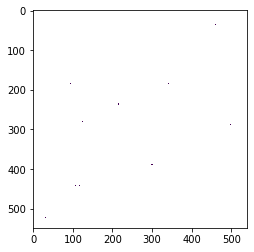

In [20]:
plt.imshow(b)

In [48]:
import rasterio
import numpy as np
from affine import Affine
from pyproj import Proj, transform

fname = r"E:\acocac\research\tile_raisg\eval\verification\mapbiomas_peryear\2004_test2.tif"

# Read raster
with rasterio.open(fname) as r:
    T0 = r.transform  # upper-left pixel corner affine transform
    p1 = Proj(r.crs)
    A = r.read()  # pixel values
    A = np.where(A == r.nodata, np.nan, A)

print(A.shape)
# All rows and columns
cols, rows = np.meshgrid(np.arange(A.shape[2]), np.arange(A.shape[1]))

# Get affine transform for pixel centres
T1 = T0 * Affine.translation(0.5, 0.5)
# Function to convert pixel row/column index (from 0) to easting/northing at centre
rc2en = lambda r, c: (c, r) * T1

# All eastings and northings (there is probably a faster way to do this)
eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)

# Project all longitudes, latitudes
p2 = Proj(proj='latlong',datum='WGS84')
longs, lats = transform(p1, p2, eastings, northings)

(18, 549, 540)


C:\Users\PAPAZ\AppData\Local\Continuum\anaconda2\envs\geothesis\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: Right multiplication will be prohibited in version 3.0


In [50]:
A.shape

(18, 549, 540)

In [38]:
import rasterio
import rasterio.features
import rasterio.warp

fname = r"E:\acocac\research\tile_raisg\eval\verification\mapbiomas_peryear\2004_test.tif"

with rasterio.open(fname) as dataset:

    # Read the dataset's valid data mask as a ndarray.
    mask = dataset.dataset_mask()

    # Extract feature shapes and values from the array.
    for geom, val in rasterio.features.shapes(
            mask, transform=dataset.transform):

        # Transform shapes from the dataset's own coordinate
        # reference system to CRS84 (EPSG:4326).
        geom = rasterio.warp.transform_geom(
            dataset.crs, 'EPSG:4326', geom, precision=6)

        # Print GeoJSON shapes to stdout.
        print(val)

0.0
1.0
